In [2]:
# pip install -U datasets
import pandas as pd
import numpy as np
from datasets import load_dataset
import sqlglot
from sqlglot import parse_one, exp
import matplotlib.pyplot as plt
import re

### Download SPIDER Dataset

In [5]:

dataset = load_dataset("spider", split="train+validation")
df = pd.DataFrame(dataset)
df.head()

,db_id,query,question,query_toks,query_toks_no_value,question_toks
0,department_management,SELECT count(*) FROM head WHERE age > 56,How many heads of the departments are older th...,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...","[How, many, heads, of, the, departments, are, ..."
1,department_management,"SELECT name , born_state , age FROM head ORD...","List the name, born state and age of the heads...","[SELECT, name, ,, born_state, ,, age, FROM, he...","[select, name, ,, born_state, ,, age, from, he...","[List, the, name, ,, born, state, and, age, of..."
2,department_management,"SELECT creation , name , budget_in_billions ...","List the creation year, name and budget of eac...","[SELECT, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","[List, the, creation, year, ,, name, and, budg..."
3,department_management,"SELECT max(budget_in_billions) , min(budget_i...",What are the maximum and minimum budget of the...,"[SELECT, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...","[What, are, the, maximum, and, minimum, budget..."
4,department_management,SELECT avg(num_employees) FROM department WHER...,What is the average number of employees of the...,"[SELECT, avg, (, num_employees, ), FROM, depar...","[select, avg, (, num_employees, ), from, depar...","[What, is, the, average, number, of, employees..."


In [6]:

def get_table_names(query):
    return list(set([(table.name, table.alias) for table in parse_one(query).find_all(exp.Table)]))
def get_column_names(query):
    return list(set([column.name for column in parse_one(query).find_all(exp.Column)]))


df['tables']= df['query'].apply(get_table_names)
df['columns'] = df['query'].apply(get_column_names)

df.head()

,db_id,query,question,query_toks,query_toks_no_value,question_toks,tables,columns
0,department_management,SELECT count(*) FROM head WHERE age > 56,How many heads of the departments are older th...,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...","[How, many, heads, of, the, departments, are, ...","[(head, )]",[age]
1,department_management,"SELECT name , born_state , age FROM head ORD...","List the name, born state and age of the heads...","[SELECT, name, ,, born_state, ,, age, FROM, he...","[select, name, ,, born_state, ,, age, from, he...","[List, the, name, ,, born, state, and, age, of...","[(head, )]","[born_state, age, name]"
2,department_management,"SELECT creation , name , budget_in_billions ...","List the creation year, name and budget of eac...","[SELECT, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","[List, the, creation, year, ,, name, and, budg...","[(department, )]","[budget_in_billions, creation, name]"
3,department_management,"SELECT max(budget_in_billions) , min(budget_i...",What are the maximum and minimum budget of the...,"[SELECT, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...","[What, are, the, maximum, and, minimum, budget...","[(department, )]",[budget_in_billions]
4,department_management,SELECT avg(num_employees) FROM department WHER...,What is the average number of employees of the...,"[SELECT, avg, (, num_employees, ), FROM, depar...","[select, avg, (, num_employees, ), from, depar...","[What, is, the, average, number, of, employees...","[(department, )]","[ranking, num_employees]"


### Classify Query (Not Used)

In [7]:
# Version 2

def classify_query(row):
    query = row.upper()
    type_lst = []

    query_dict = {
        'ddl': ['CREATE', 'ALTER', 'DROP', 'TRUNCATE'],
        'dml': ['INSERT', 'DELETE', 'UPDATE'],
        'tcl': ['SAVEPOINT', 'COMMIT', 'ROLLBACK'],
        'aggregate': ['COUNT', 'SUM', 'AVG', 'MAX', 'MIN', 'GROUP BY', 'HAVING', 'ORDER BY', 'DISTINCT', 'ASC', 'DESC'],
        'filter': ['WHERE', 'AND', 'OR', 'BETWEEN', 'LIKE', 'IN', 'IS NULL', 'IS NOT NULL'],
        'combine': ['JOIN', 'UNION', 'INTERSECT', 'EXCEPT']
    }

    for key, value in query_dict.items():
        # Bound the word using regex
        if any(re.search(r'\b' + keyword + r'\b', query) for keyword in value):
            type_lst.append(key)
            
    if not type_lst:
        type_lst.append('standard')
            
    return type_lst

In [8]:
df['query_type'] = df['query'].apply(classify_query)
df[['query', 'question', 'query_type']]
# df.to_csv('spider_data_with_type.csv')

,query,question,query_type
0,SELECT count(*) FROM head WHERE age > 56,How many heads of the departments are older th...,"[aggregate, filter]"
1,"SELECT name , born_state , age FROM head ORD...","List the name, born state and age of the heads...",[aggregate]
2,"SELECT creation , name , budget_in_billions ...","List the creation year, name and budget of eac...",[standard]
3,"SELECT max(budget_in_billions) , min(budget_i...",What are the maximum and minimum budget of the...,[aggregate]
4,SELECT avg(num_employees) FROM department WHER...,What is the average number of employees of the...,"[aggregate, filter]"
...,...,...,...
8029,SELECT Citizenship FROM singer WHERE Birth_Yea...,What are the citizenships that are shared by s...,"[filter, combine]"
8030,SELECT count(*) FROM Other_Available_Features,How many available features are there in total?,[aggregate]
8031,SELECT T2.feature_type_name FROM Other_Availab...,What is the feature type name of feature AirCon?,"[filter, combine]"
8032,SELECT T2.property_type_description FROM Prope...,Show the property type descriptions of propert...,"[aggregate, combine]"


In [9]:
def create_columns_based_on_types(query_type: list, types: str):

    if types in query_type:
        return 1
    else:
        return 0
    
df['aggregate'] = df['query_type'].apply(create_columns_based_on_types, types = 'aggregate')
df['combine'] = df['query_type'].apply(create_columns_based_on_types, types = 'combine')
df['standard'] = df['query_type'].apply(create_columns_based_on_types, types = 'standard')
df['filter'] = df['query_type'].apply(create_columns_based_on_types, types = 'filter')

In [10]:
df['query_type_str'] = df['query_type'].apply(lambda x: '-'.join(x))
df.query_type_str.unique()

array(['aggregate-filter', 'aggregate', 'standard', 'filter',
       'aggregate-filter-combine', 'filter-combine', 'aggregate-combine',
       'combine'], dtype=object)

### Exploratory Analysis

In [11]:
import nltk
from nltk.corpus import stopwords
from collections import Counter

def get_distribution(df, col_to_inspect, stop_words_remove = True, query_type = None):
    if query_type:
        df_sub = df[df[query_type]==1]
    else:
        df_sub = df
    
    if stop_words_remove:
        # nltk.download('stopwords')
        stopwords_lst = stopwords.words('english')
        stopwords_lst.append('')
    else:
        stopwords_lst = []

    words = df_sub[col_to_inspect].sum()
    words = [re.sub(r'[^\w\s]', '', word) for word in words]
    words = [word for word in words if word.isalpha()]
    words = [word.lower() for word in words]
    words = [word for word in words if word not in stopwords_lst]

    word_counts = Counter(words)
    most_common_words = word_counts.most_common(40)
    print(word_counts.most_common(100))

    words, frequencies = zip(*most_common_words)

    fig, ax = plt.subplots(figsize = (10, 4))
    bars = ax.bar(words, frequencies)

    ax.set_xlabel('Keywords')
    ax.set_ylabel('Frequency')
    ax.set_xticklabels(words, rotation = 90)
    ax.set_title(query_type)

    # Placing text annotations on the top of the bars with the respective value
    for bar in bars:
        height = bar.get_height()  # This is the value you want to display
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom', rotation=90)

    plt.show()

[('number', 1274), ('name', 987), ('many', 922), ('names', 811), ('find', 776), ('average', 585), ('show', 522), ('list', 485), ('order', 418), ('id', 399), ('students', 372), ('total', 365), ('different', 335), ('count', 289), ('type', 266), ('distinct', 259), ('least', 252), ('first', 250), ('return', 232), ('last', 201), ('customers', 197), ('maximum', 184), ('code', 178), ('whose', 177), ('ids', 174), ('ordered', 172), ('year', 154), ('age', 152), ('descending', 151), ('customer', 147), ('highest', 146), ('amount', 146), ('give', 143), ('city', 140), ('one', 135), ('largest', 134), ('product', 133), ('ascending', 132), ('products', 131), ('department', 128), ('price', 126), ('two', 126), ('players', 122), ('employees', 117), ('minimum', 116), ('date', 116), ('countries', 115), ('country', 115), ('alphabetical', 113), ('student', 108), ('cities', 104), ('people', 104), ('types', 104), ('courses', 91), ('used', 89), ('sorted', 88), ('codes', 88), ('rating', 84), ('made', 82), ('commo

/var/folders/l5/2302s0j90898y2c73n3g1wmr0000gn/T/ipykernel_48922/3580799353.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation = 90)


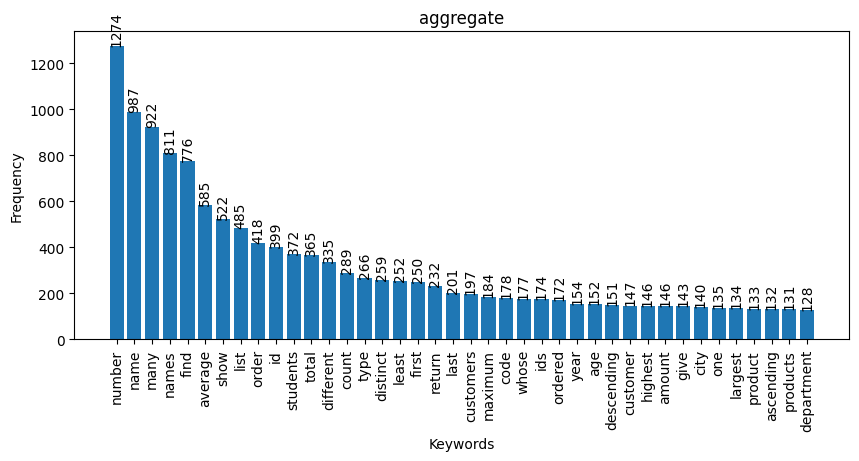

In [12]:
get_distribution(df = df, col_to_inspect = 'question_toks', query_type = 'aggregate')

[('name', 1092), ('names', 973), ('find', 656), ('number', 507), ('show', 412), ('first', 340), ('id', 317), ('students', 299), ('last', 285), ('many', 268), ('list', 261), ('ids', 185), ('average', 173), ('whose', 169), ('customers', 163), ('customer', 155), ('return', 153), ('give', 149), ('least', 148), ('total', 147), ('type', 131), ('student', 126), ('order', 121), ('course', 111), ('code', 111), ('department', 109), ('product', 109), ('date', 104), ('city', 100), ('named', 100), ('products', 97), ('members', 89), ('players', 87), ('one', 85), ('staff', 85), ('details', 84), ('different', 84), ('courses', 83), ('distinct', 82), ('used', 79), ('year', 77), ('title', 73), ('count', 71), ('amount', 71), ('country', 71), ('description', 71), ('cities', 69), ('songs', 69), ('employees', 67), ('two', 65), ('dates', 63), ('made', 63), ('document', 63), ('countries', 62), ('highest', 61), ('age', 60), ('balance', 60), ('tracks', 58), ('rating', 56), ('friends', 56), ('titles', 54), ('docu

/var/folders/l5/2302s0j90898y2c73n3g1wmr0000gn/T/ipykernel_48922/3580799353.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation = 90)


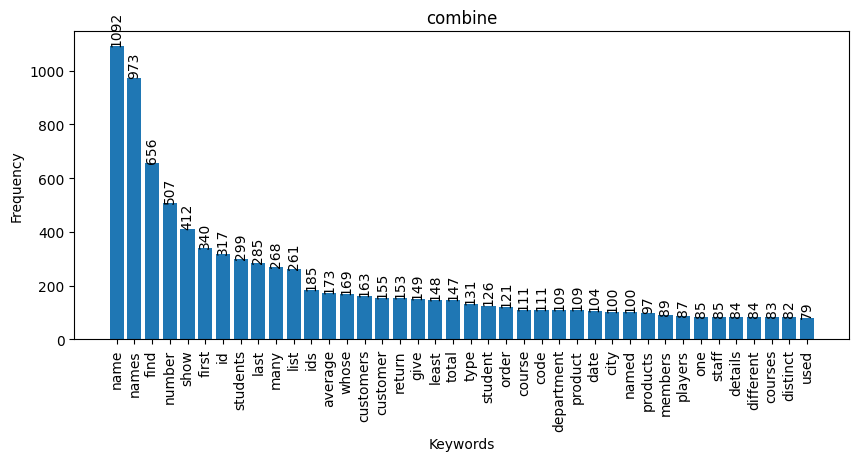

In [13]:
get_distribution(df = df, col_to_inspect = 'question_toks', query_type = 'combine')

[('names', 986), ('name', 933), ('find', 734), ('number', 457), ('many', 427), ('whose', 377), ('first', 337), ('show', 331), ('students', 308), ('average', 290), ('last', 280), ('list', 256), ('id', 196), ('code', 194), ('type', 178), ('ids', 172), ('return', 166), ('give', 154), ('total', 153), ('customers', 152), ('named', 144), ('customer', 130), ('year', 128), ('city', 125), ('department', 124), ('employees', 121), ('student', 109), ('products', 109), ('count', 108), ('age', 107), ('distinct', 105), ('players', 102), ('product', 99), ('date', 97), ('order', 94), ('cities', 87), ('price', 86), ('state', 85), ('higher', 85), ('country', 85), ('description', 85), ('different', 82), ('songs', 82), ('course', 81), ('dates', 81), ('staff', 79), ('members', 78), ('countries', 78), ('document', 78), ('titles', 74), ('salary', 72), ('least', 71), ('title', 70), ('maximum', 69), ('amount', 68), ('greater', 66), ('status', 64), ('details', 64), ('people', 64), ('courses', 61), ('produced', 6

/var/folders/l5/2302s0j90898y2c73n3g1wmr0000gn/T/ipykernel_48922/3580799353.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation = 90)


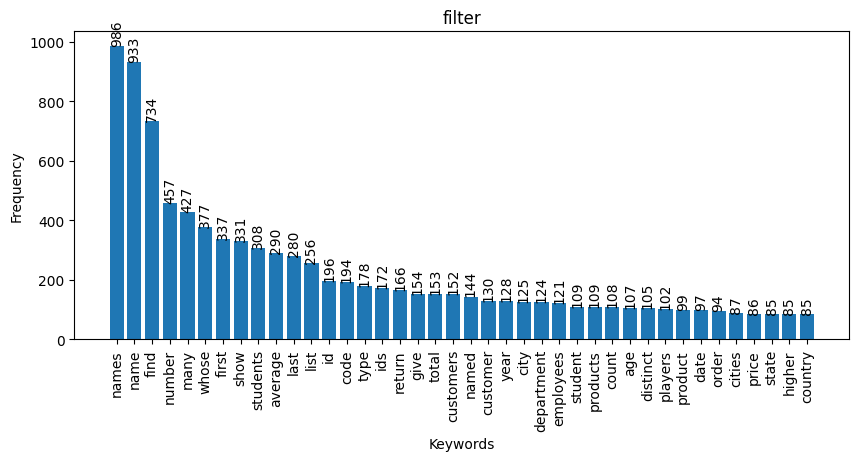

In [14]:
get_distribution(df = df, col_to_inspect = 'question_toks', query_type = 'filter')

### Explore Common SQL Query Key Words

In [15]:

def get_sql_keywords(row):
    
    toks = [item.lower() for item in row['query_toks']]
    tabname = [item.lower() for tuple in row['tables'] for item in tuple]
    colname = [item.lower() for item in row['columns']]
    
    tok_filter = [item for item in toks if item.isalpha()]
    tok_filter = [item for item in tok_filter if item not in tabname and item not in colname]
    
    sql_key_word_list = ['COUNT', 'SUM', 'AVG', 'MAX', 'MIN', 'GROUP', 'HAVING', 'ORDER', 'DISTINCT', 'ASC', 'DESC',
                         'WHERE', 'AND', 'OR', 'BETWEEN', 'LIKE', 'IN', 'NULL', 'NOT',
                         'JOIN', 'UNION', 'INTERSECT', 'EXCEPT', 'AS', 'SELECT', 'FROM', 'LIMIT']
    sql_key_word_list = [item.lower() for item in sql_key_word_list]
    
    tok_filter = [item for item in tok_filter if item in sql_key_word_list]

    return ','.join(list(set(tok_filter)))

df['sql_keywords'] = df.apply(get_sql_keywords, axis = 1)
df.head()

,db_id,query,question,query_toks,query_toks_no_value,question_toks,tables,columns,query_type,aggregate,combine,standard,filter,query_type_str,sql_keywords
0,department_management,SELECT count(*) FROM head WHERE age > 56,How many heads of the departments are older th...,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...","[How, many, heads, of, the, departments, are, ...","[(head, )]",[age],"[aggregate, filter]",1,0,0,1,aggregate-filter,"where,count,from,select"
1,department_management,"SELECT name , born_state , age FROM head ORD...","List the name, born state and age of the heads...","[SELECT, name, ,, born_state, ,, age, FROM, he...","[select, name, ,, born_state, ,, age, from, he...","[List, the, name, ,, born, state, and, age, of...","[(head, )]","[born_state, age, name]",[aggregate],1,0,0,0,aggregate,"from,order,select"
2,department_management,"SELECT creation , name , budget_in_billions ...","List the creation year, name and budget of eac...","[SELECT, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","[List, the, creation, year, ,, name, and, budg...","[(department, )]","[budget_in_billions, creation, name]",[standard],0,0,1,0,standard,"from,select"
3,department_management,"SELECT max(budget_in_billions) , min(budget_i...",What are the maximum and minimum budget of the...,"[SELECT, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...","[What, are, the, maximum, and, minimum, budget...","[(department, )]",[budget_in_billions],[aggregate],1,0,0,0,aggregate,"from,max,min,select"
4,department_management,SELECT avg(num_employees) FROM department WHER...,What is the average number of employees of the...,"[SELECT, avg, (, num_employees, ), FROM, depar...","[select, avg, (, num_employees, ), from, depar...","[What, is, the, average, number, of, employees...","[(department, )]","[ranking, num_employees]","[aggregate, filter]",1,0,0,1,aggregate-filter,"where,select,and,between,from,avg"


### Explore by Removing "Combine" Category and Predict SQL Queries' Category

In [17]:
from transformers import BertTokenizer, BertModel
import torch
from scipy.spatial.distance import cosine

# Function to generate averaged embeddings
def generate_embedding(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Get the embeddings and average them across the sequence length dimension
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings


def predict_question_type(question:str, query_dict:dict, query_embed:dict, tokenizer, model):

    # Compute embeddings
    question_embedding = generate_embedding(question, tokenizer, model)

    prediction = []
    threshold = 0.4
    for query_type in query_dict.keys():
        keyword = query_dict[query_type]
        keyword_embeddings = query_embed[query_type]
        similarities = [1 - cosine(question_embedding, keyword_embedding) for keyword_embedding in keyword_embeddings]
        
        if max(similarities) > threshold:
            prediction.append(1)
            # prediction.append(query_type)
            # index = similarities.index(max(similarities))
            # print(f'Question belongs to type: {query_type}, semantically similar to word: {keyword[index]}')
        else:
            prediction.append(0)
            
    if sum(prediction) == 0:
        prediction.append(1)
    else:
        prediction.append(0)
        
    return prediction


/Users/chenkangan/Documents/UCL DSML/Statistical Natural Languge Processing/project/.venv/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/chenkangan/Documents/UCL DSML/Statistical Natural Languge Processing/project/.venv/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [18]:
# Load pre-trained model tokenizer (vocabulary) and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Ensure the model is in evaluation mode
model.eval()

query_dict = {
    'aggregate': ['COUNT', 'SUM', 'AVERAGE', 'MAXIMUM', 'MINIMUM', 'GROUP BY', 'ORDER BY', 'DISTINCT', 'ASCENDING', 'DESCENDING'],
    'filter': ['WHERE', 'AND', 'OR', 'BETWEEN', 'LIKE', 'IN', 'IS NULL', 'IS NOT NULL'],
    # 'combine': ['JOIN', 'UNION', 'INTERSECT', 'EXCEPT']
}

query_embed = {}

for query_type in query_dict.keys():
    query_embed[query_type] = [generate_embedding(keyword, tokenizer, model) for keyword in query_dict[query_type]]



In [19]:
predict_question_type("List the players' salary in descending order", query_dict, query_embed, tokenizer, model)

[1, 0, 0]

In [20]:
new_df = df[['query', 'question', 'tables', 'columns', 'aggregate', 'filter', 'standard']]
new_df.head()

,query,question,tables,columns,aggregate,filter,standard
0,SELECT count(*) FROM head WHERE age > 56,How many heads of the departments are older th...,"[(head, )]",[age],1,1,0
1,"SELECT name , born_state , age FROM head ORD...","List the name, born state and age of the heads...","[(head, )]","[born_state, age, name]",1,0,0
2,"SELECT creation , name , budget_in_billions ...","List the creation year, name and budget of eac...","[(department, )]","[budget_in_billions, creation, name]",0,0,1
3,"SELECT max(budget_in_billions) , min(budget_i...",What are the maximum and minimum budget of the...,"[(department, )]",[budget_in_billions],1,0,0
4,SELECT avg(num_employees) FROM department WHER...,What is the average number of employees of the...,"[(department, )]","[ranking, num_employees]",1,1,0


In [21]:
new_df['prediction'] = df['question'].apply(predict_question_type, query_dict = query_dict, query_embed = query_embed, tokenizer=tokenizer, model=model)

/var/folders/l5/2302s0j90898y2c73n3g1wmr0000gn/T/ipykernel_48922/790536600.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['prediction'] = df['question'].apply(predict_question_type, query_dict = query_dict, query_embed = query_embed, tokenizer=tokenizer, model=model)


In [22]:
new_df['target'] = new_df[['aggregate', 'filter', 'standard']].values.tolist()
new_df.head()

/var/folders/l5/2302s0j90898y2c73n3g1wmr0000gn/T/ipykernel_48922/2939333243.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['target'] = new_df[['aggregate', 'filter', 'standard']].values.tolist()


,query,question,tables,columns,aggregate,filter,standard,prediction,target
0,SELECT count(*) FROM head WHERE age > 56,How many heads of the departments are older th...,"[(head, )]",[age],1,1,0,"[1, 1, 0]","[1, 1, 0]"
1,"SELECT name , born_state , age FROM head ORD...","List the name, born state and age of the heads...","[(head, )]","[born_state, age, name]",1,0,0,"[1, 0, 0]","[1, 0, 0]"
2,"SELECT creation , name , budget_in_billions ...","List the creation year, name and budget of eac...","[(department, )]","[budget_in_billions, creation, name]",0,0,1,"[1, 1, 0]","[0, 0, 1]"
3,"SELECT max(budget_in_billions) , min(budget_i...",What are the maximum and minimum budget of the...,"[(department, )]",[budget_in_billions],1,0,0,"[1, 1, 0]","[1, 0, 0]"
4,SELECT avg(num_employees) FROM department WHER...,What is the average number of employees of the...,"[(department, )]","[ranking, num_employees]",1,1,0,"[0, 1, 0]","[1, 1, 0]"


In [23]:
correct_predictions = (new_df['prediction'] == new_df['target']).sum()
total_predictions = len(df)
accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 25.94%


### Schema-related masking

In [23]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

In [24]:
# Example sentence
sentence = "Which head's name has the substring 'Ha'? List the id and name."

# List of database elements to mask
db_elements = ['id', 'name', 'head']

# Function to mask database elements in a sentence
def mask_db_elements(sentence, db_elements):
    for element in db_elements:
        # Using word boundaries (\b) to match whole words only
        regex_pattern = r'\b' + re.escape(element) + r'\b'
        sentence = re.sub(regex_pattern, '[masked]', sentence, flags=re.IGNORECASE)
    return sentence

# Masking the sentence
masked_sentence = mask_db_elements(sentence, db_elements)
print(masked_sentence)


Which [masked]'s [masked] has the substring 'Ha'? List the [masked] and [masked].


In [25]:
from question_masking import *
# Database schema
db_schema = {
        'department': ['id', 'name', 'num_employees', 'creation', 'name', 'budget_in_billions', 'head'],
    }

common_schema_related_toks = ['student', 'course', 'department', 'age', 'course', 'ids', 'car', 'player', 'class', 'cities', 'employee']
    
# Example usage
question = "Which head's name has the substring 'Ha'? List the id and name."
masked_question = mask_question(question, db_schema, common_schema_related_toks)

print(masked_question)


Which [MASK] [MASK] has the substring 'Ha'? List the [MASK] and [MASK]


In [26]:
df['schema_toks'] = df.apply(get_schema_related_toks, axis = 1)
df['masked_question'] = df.apply(mask_question_df, common_schema_related_toks = common_schema_related_toks, axis = 1)
df['masked_question_toks'] = df['masked_question'].apply(lambda x: x.split(' '))
df['join_involved'] = df['sql_keywords'].apply(lambda x: True if 'join' in x else False)
df.head()

,db_id,query,question,query_toks,query_toks_no_value,question_toks,tables,columns,query_type,aggregate,combine,standard,filter,query_type_str,sql_keywords,schema_toks,masked_question,masked_question_toks,join_involved
0,department_management,SELECT count(*) FROM head WHERE age > 56,How many heads of the departments are older th...,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...","[How, many, heads, of, the, departments, are, ...","[(head, )]",[age],"[aggregate, filter]",1,0,0,1,aggregate-filter,"where,count,from,select","[head, age]",How many [MASK] of the [MASK] are older than 56 ?,"[How, many, [MASK], of, the, [MASK], are, olde...",False
1,department_management,"SELECT name , born_state , age FROM head ORD...","List the name, born state and age of the heads...","[SELECT, name, ,, born_state, ,, age, FROM, he...","[select, name, ,, born_state, ,, age, from, he...","[List, the, name, ,, born, state, and, age, of...","[(head, )]","[born_state, age, name]",[aggregate],1,0,0,0,aggregate,"from,order,select","[head, born_state, age, name]",List the [MASK] [MASK] [MASK] and [MASK] of th...,"[List, the, [MASK], [MASK], [MASK], and, [MASK...",False
2,department_management,"SELECT creation , name , budget_in_billions ...","List the creation year, name and budget of eac...","[SELECT, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","[List, the, creation, year, ,, name, and, budg...","[(department, )]","[budget_in_billions, creation, name]",[standard],0,0,1,0,standard,"from,select","[department, budget_in_billions, creation, name]","List the [MASK] year, [MASK] and [MASK] of eac...","[List, the, [MASK], year,, [MASK], and, [MASK]...",False
3,department_management,"SELECT max(budget_in_billions) , min(budget_i...",What are the maximum and minimum budget of the...,"[SELECT, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...","[What, are, the, maximum, and, minimum, budget...","[(department, )]",[budget_in_billions],[aggregate],1,0,0,0,aggregate,"from,max,min,select","[department, budget_in_billions]",What are the maximum and minimum [MASK] of the...,"[What, are, the, maximum, and, minimum, [MASK]...",False
4,department_management,SELECT avg(num_employees) FROM department WHER...,What is the average number of employees of the...,"[SELECT, avg, (, num_employees, ), FROM, depar...","[select, avg, (, num_employees, ), from, depar...","[What, is, the, average, number, of, employees...","[(department, )]","[ranking, num_employees]","[aggregate, filter]",1,0,0,1,aggregate-filter,"where,select,and,between,from,avg","[department, ranking, num_employees]",What is the average number of [MASK] of the [M...,"[What, is, the, average, number, of, [MASK], o...",False


In [27]:
df_simp = df[['question', 'masked_question', 'masked_question_toks', 'query', 'schema_toks', 'tables', 'columns', 'sql_keywords', 'join_involved']]

inspect_num = 190 #100 #11
print(df_simp.iloc[inspect_num].query)
print(df_simp.iloc[inspect_num].question)
print(df_simp.iloc[inspect_num].masked_question)
print(df_simp.iloc[inspect_num].schema_toks)

SELECT T1.name ,  T1.long ,  avg(T2.duration) FROM station AS T1 JOIN trip AS T2 ON T1.id  =  T2.start_station_id GROUP BY T2.start_station_id
For each start station id, what is its name, longitude and average duration of trips started there?
For each [MASK] [MASK] id, what is its [MASK] [MASK] and average [MASK] of [MASK] [MASK] there?
['station', 'trip', 'id', 'duration', 'start_station_id', 'name', 'long']


[('mask', 31229), ('find', 1238), ('number', 1232), ('many', 936), ('show', 892), ('list', 727), ('average', 581), ('whose', 403), ('return', 372), ('order', 362), ('different', 338), ('total', 322), ('least', 271), ('give', 263), ('distinct', 255), ('count', 242), ('first', 214), ('maximum', 189), ('id', 169), ('last', 164), ('ordered', 148), ('descending', 148), ('one', 143), ('highest', 142), ('largest', 134), ('two', 132), ('ascending', 130), ('used', 130), ('minimum', 118), ('alphabetical', 113), ('corresponding', 101), ('higher', 90), ('made', 90), ('sorted', 88), ('names', 85), ('common', 82), ('name', 79), ('top', 76), ('full', 74), ('less', 73), ('produced', 73), ('greater', 71), ('lowest', 68), ('people', 67), ('greatest', 66), ('ids', 63), ('live', 62), ('either', 61), ('times', 61), ('across', 54), ('every', 53), ('tv', 53), ('never', 52), ('living', 50), ('please', 47), ('members', 47), ('three', 46), ('information', 46), ('taught', 46), ('sort', 45), ('female', 45), ('num

/var/folders/l5/2302s0j90898y2c73n3g1wmr0000gn/T/ipykernel_48922/3580799353.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation = 90)


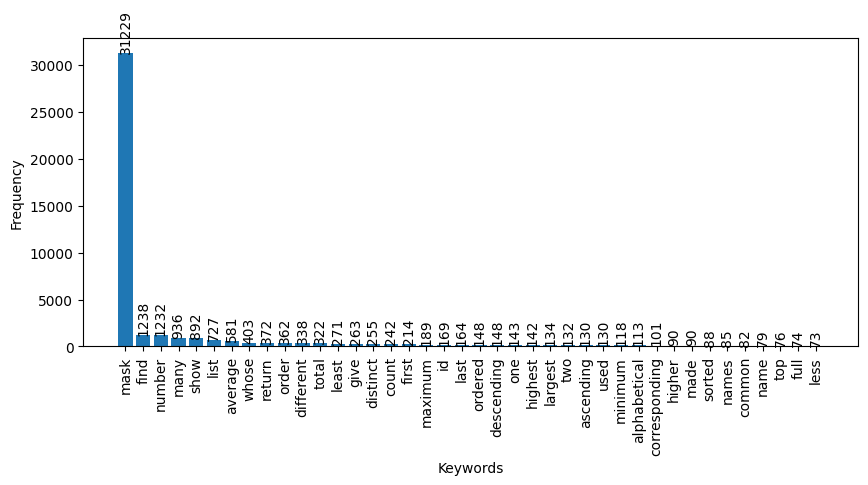

In [28]:
get_distribution(df = df_simp, col_to_inspect = 'masked_question_toks', query_type = None)

In [33]:
# df_simp.to_csv('spider_data_with_masked_questions_v2.csv')

### Load MD File (SQL Documentations)

In [29]:
df = pd.read_csv('md_data.csv')
df.head()

,title,summary,content
0,SELECT,SELECT: used to select data from a database,SELECT: used to select data from a database.\n...
1,DISTINCT,DISTINCT: filters away duplicate values and re...,DISTINCT: filters away duplicate values and re...
2,WHERE,WHERE: used to filter records/rows,WHERE: used to filter records/rows.\nSELECT co...
3,ORDER BY,ORDER BY: used to sort the result-set in ascen...,ORDER BY: used to sort the result-set in ascen...
4,SELECT TOP,SELECT TOP: used to specify the number of reco...,SELECT TOP: used to specify the number of reco...


In [31]:
# Function to search for the keyword in a specific column
def search_in_document(df, column_name, keyword):

    if column_name in df.columns:
        mask = df[column_name].apply(lambda x: keyword in str(x).lower())
        
        result_dict = {}

        for index, row in df[mask].iterrows():
            result_dict[row['title']] = {'summary': row['summary'],
                                        'content': row['content']}
            
        return result_dict

    else:
        raise ValueError(f"Column '{column_name}' is not found in DataFrame.")
    
    
# Get rows where the keyword is in 'colA'
result = search_in_document(df, 'title', 'select')

result


{'SELECT': {'summary': 'SELECT: retrieve a view',
  'content': 'SELECT: retrieve a view.\nSELECT * FROM view_name;\n'},
 'SELECT TOP': {'summary': 'SELECT TOP: used to specify the number of records to return from top of table',
  'content': 'SELECT TOP: used to specify the number of records to return from top of table.\nSELECT TOP number columns_names FROM table_name WHERE condition;\nSELECT TOP percent columns_names FROM table_name WHERE condition;\nNot all database systems support SELECT TOP. The MySQL equivalent is the LIMIT clause\nSELECT column_names FROM table_name LIMIT offset, count;\n'}}